# Blatt 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, curve_fit
from scipy.misc import derivative
from matplotlib.patches import Ellipse

Create a reasonable mock data set with events as a function of energy (between 10
GeV and 100 GeV) and cos(θ) between 0 and 1. Assuming a known set of mixing
parameters (feel free to use the functions provided in the example notebook in the
Github repository, which already includes reasonable default parameters)

In [9]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy) 

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)

    liste=[]
    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            
            i=i+1
            liste.append([e,c,int(event_random)])
    data = pd.DataFrame(liste, columns=['energy', 'cosdec', 'events'])
    return data

In [24]:
def dataset(steps, sin2theta=0.9, dm2=2.4e-3, Plotten=False):
    cosdec =  np.linspace(0, 1, steps) # n steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, steps) # n steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
    # run the experiment 
    data=run_experiment(energy,cosdec,sin2theta,dm2)

    if Plotten==True:
        plt.hist(data['events'], bins=20)
        plt.yscale('log')
        plt.show() 

    return data

Once you have your mock data set, fit for the two mixing parameters. Please compute
the errors on the parameters through the minimum-variance / Cramer-Rao bound by
obtaining numerically the corresponding derivatives

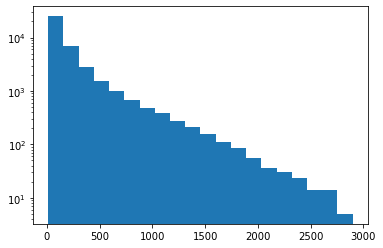

sin2theta = 0.9003588630016492 $\pm$ 0.00014796448887570402
dm2 = 0.00240002704184877 $\pm$ 2.265627546005045e-07


In [21]:
def model(data, sin2theta, dm2):
    energy, cosdec = data
    return atmo_event_rate(energy, cosdec, sin2theta, dm2)

data = dataset(200, Plotten=True)
popt, pcov = curve_fit(model, xdata=np.vstack((data["energy"], data["cosdec"])), ydata=data["events"], p0 = [0.5, 1e-3])
perr = np.sqrt(np.diag(pcov))
print(f"sin2theta = {popt[0]} $\pm$ {perr[0]}")
print(f"dm2 = {popt[1]} $\pm$ {perr[1]}")

In [15]:
def logprobability_sin(sin2theta, dm2, energy, cos_theta):
    if energy == 0:
        return 0
    flux = 1e5*energy**-1.7
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    #if flux*osc_prop <= 0:
        #return 0
    return np.log(flux*osc_prop)


def logprobability_dm2(dm2, sin2theta,  energy, cos_theta):
    if energy == 0:
        return 0
    flux = 1e5*energy**-1.7
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    return np.log(flux*osc_prop)

def CramerRao_bound(data, sin2theta, dm2):
    energy, cosdec = data["energy"].to_numpy(), data["cosdec"].to_numpy()
    #calculate numerical derivatives of the LLH wrt sin2theta and dm2
    dLLH_dm2 = 0
    dLLH_sin2theta = 0
    for i in range(len(energy)):
        dLLH_dm2 += derivative(logprobability_dm2, dm2, dx=1e-4, args = (sin2theta, energy[i], cosdec[i]))
        dLLH_sin2theta += derivative(logprobability_sin, sin2theta,dx=1e-4, args = (dm2, energy[i], cosdec[i]))
    return  1/dLLH_dm2**2, 1/dLLH_sin2theta**2

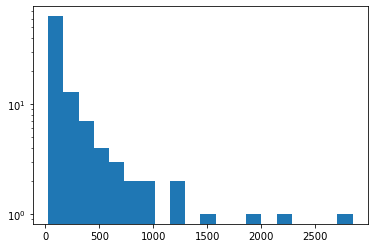

Bounds for sin2theta and dm2 for 10 events:
0.007723928724815024
9.652700610661217e-05


In [22]:
data = dataset(10, Plotten=True) 
sigma_dm2, sigma_sin2theta = np.sqrt(CramerRao_bound(data, 0.9, 2.4e-3))

print('Bounds for sin2theta and dm2 for 10 events:')
print(sigma_sin2theta)
print(sigma_dm2)

Repeat step 1 a hundred times and each time count how often your measurement falls
inside the 1-dimensional errors. Also, plot the two dimensional error ellipse obtained
from error propagation and count the number of fits that result in parameters that fall
inside the contours.

89


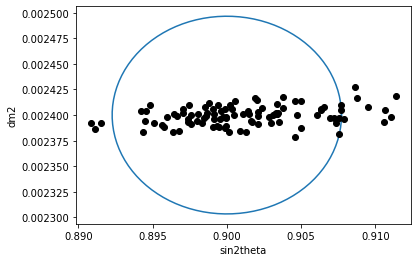

In [26]:
count = 0 
X=[]
Y=[]

for i in range(100):
    data = dataset(10)
    popt, pcov = curve_fit(model, xdata=np.vstack((data["energy"], data["cosdec"])), ydata=data["events"], p0=[0.5, 1e-3])
    X.append(popt[0])
    Y.append(popt[1])
    if abs(popt[0] - 0.9) < sigma_sin2theta and abs(popt[1] - 2.4e-3) < sigma_dm2:
        count += 1

print(count)

ell = np.linspace(0, 2*np.pi, 100)
plt.plot(0.9+sigma_sin2theta*np.cos(ell) , 2.4e-3+sigma_dm2*np.sin(ell) )
plt.plot(X,Y, 'ko')
plt.xlabel("sin2theta")
plt.ylabel("dm2")
plt.show()